### Import Libraries

In [13]:
import nibabel
import ants
import numpy as np
import pandas as pd
import os
from math import ceil
import multiprocessing as mp
import re
import matplotlib.pyplot as plt
import glob

from nilearn.image import load_img, smooth_img, resample_img, get_data
from nilearn.plotting import show, view_img, plot_img
import plotly.graph_objects as go

### Let's take a look at the original preprocessing

In [9]:
data_path = "/code/data/dhcp_rel2/ref"
ref_path = os.path.join(data_path, "sub-CC00058XX09_ses-11300_desc-restore_T2w.nii.gz")
ref_mask_path = os.path.join(data_path, "sub-CC00058XX09_ses-11300_desc-bet_space-T2w_brainmask.nii.gz")
og_path = os.path.join(data_path, "samples")
stripped_path = os.path.join(data_path, "stripped")
registered_path = os.path.join(data_path, "registered")
self_registered_path = os.path.join(data_path, "self_registered")
self_normalized_path = os.path.join(data_path, "self_normalized")

In [22]:
img = ants.image_read(ref_path)
# img = img.numpy()

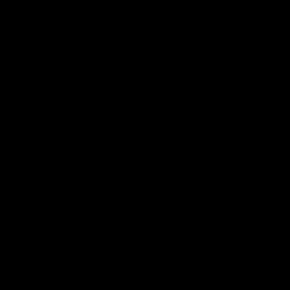

In [21]:
from PIL import Image

Image.fromarray(img[:,:,128], mode="1")

In [75]:
l1_count = 0
l5_count = 0

for file in os.listdir(self_registered_path):
    file_path = os.path.join(self_registered_path, file)
    
    file_level = file[:-7][-1]
    
    if file_level == '1':
        l1_count += 1
    elif file_level == '5':
        l5_count += 1
    
print(l1_count, l5_count)

125 8


In [24]:
l1 = np.load(os.path.join(self_normalized_path, "dhcp_level1.npy"))

In [70]:
ref = ants.image_read(ref_path).numpy()
ref_mask = ants.image_read(ref_mask_path).numpy()
ref_img = ref * ref_mask

(290, 290, 203) (290, 290, 203) (256, 256, 256)


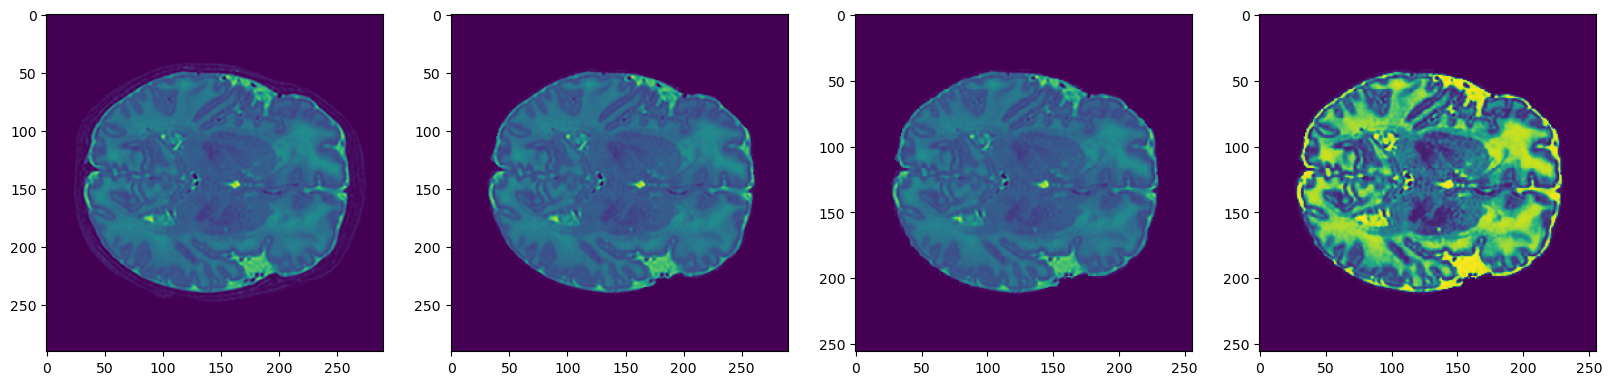

In [25]:
### original vs stripped vs registered vs final data from original experiments
og = ants.image_read(os.path.join(og_path, "sub-CC00058XX09_ses-11300_desc-restore_T2w.nii.gz")).numpy()
stripped = ants.image_read(os.path.join(stripped_path, "sub-CC00058XX09_1.nii.gz")).numpy()
registered = ants.image_read(os.path.join(self_registered_path, "sub-CC00058XX09_1.nii.gz")).numpy()

print(og.shape, stripped.shape, registered.shape)
fig, ax = plt.subplots(1, 4, figsize=(20,20))
    
ax[0].imshow(og[:,:,101])
ax[1].imshow(stripped[:,:,101])
ax[2].imshow(registered[:,:,128])
ax[3].imshow(l1[0][:,:,128])

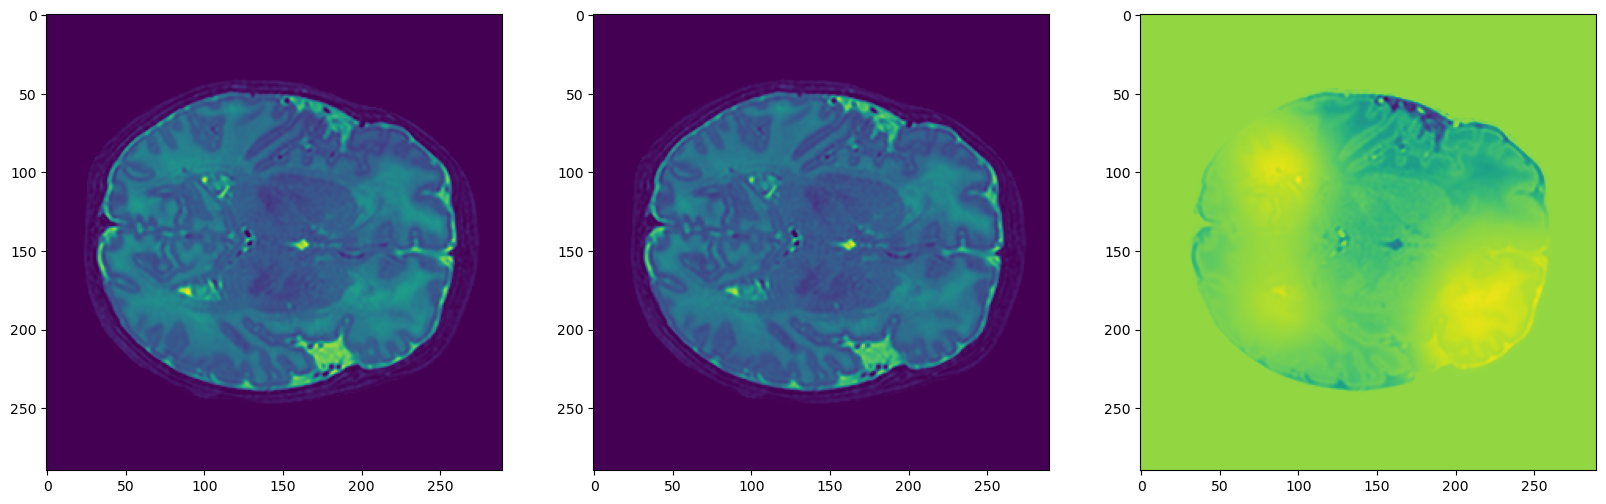

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].imshow(ref[:,:,101])
ax[1].imshow(og[:,:,101])
ax[2].imshow(ref[:,:,101] - og[:,:,101])

### Registration and deregistration

In [54]:
ref_img = ants.image_read(os.path.join(og_path, "sub-CC00058XX09_ses-11300_desc-restore_T2w.nii.gz"))
img = ants.image_read(os.path.join(og_path, "sub-CC00060XX03_ses-12501_desc-restore_T2w.nii.gz"))

reg = ants.registration(fixed=ref_img, moving=img, type_of_transform='AffineFast')

In [61]:
dereg = ants.apply_transforms(fixed=img, moving=reg['warpedmovout'], transformlist=reg['invtransforms'])

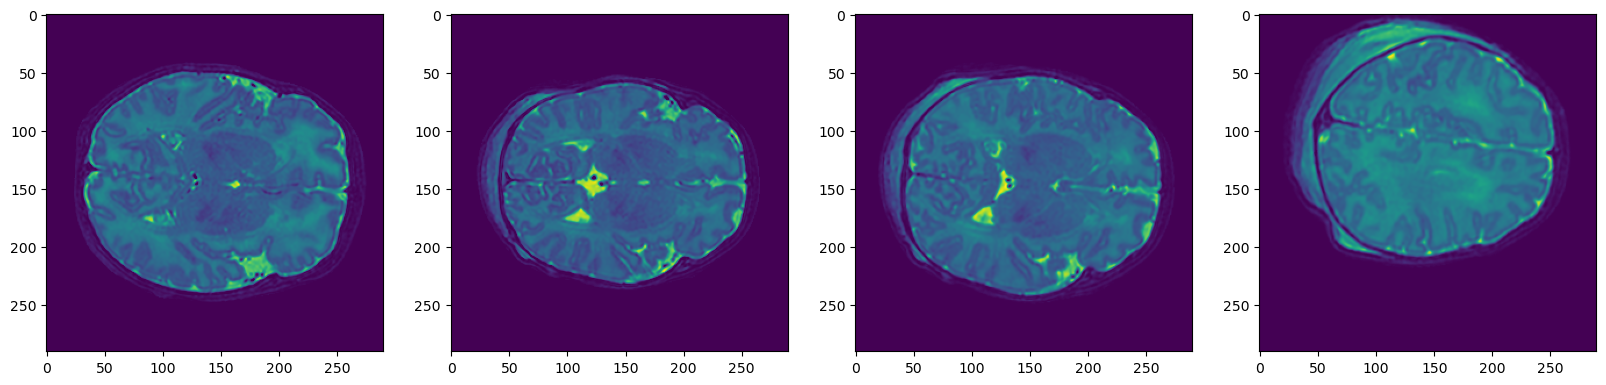

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(ref_img.numpy()[:,:,101])
ax[1].imshow(img.numpy()[:,:,101])
ax[2].imshow(reg['warpedmovout'].numpy()[:,:,101])
ax[3].imshow(dereg.numpy()[:,:,101])

In [63]:
dereg

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (290, 290, 203)
	 Spacing    : (0.5, 0.5, 0.5)
	 Origin     : (-62.9333, 54.4253, -35.4019)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [41]:
img

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (290, 290, 203)
	 Spacing    : (0.5, 0.5, 0.5)
	 Origin     : (-62.9333, 54.4253, -35.4019)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [65]:
reg['invtransforms']

['/tmp/tmpavz5hgas0GenericAffine.mat']

### Masking

In [72]:
ref = ants.image_read(ref_path)
ref_mask = ants.image_read(ref_mask_path) 
ref_img = ref.numpy() * ref_mask.numpy()

ants_masked = ants.mask_image(ref, ref_mask)

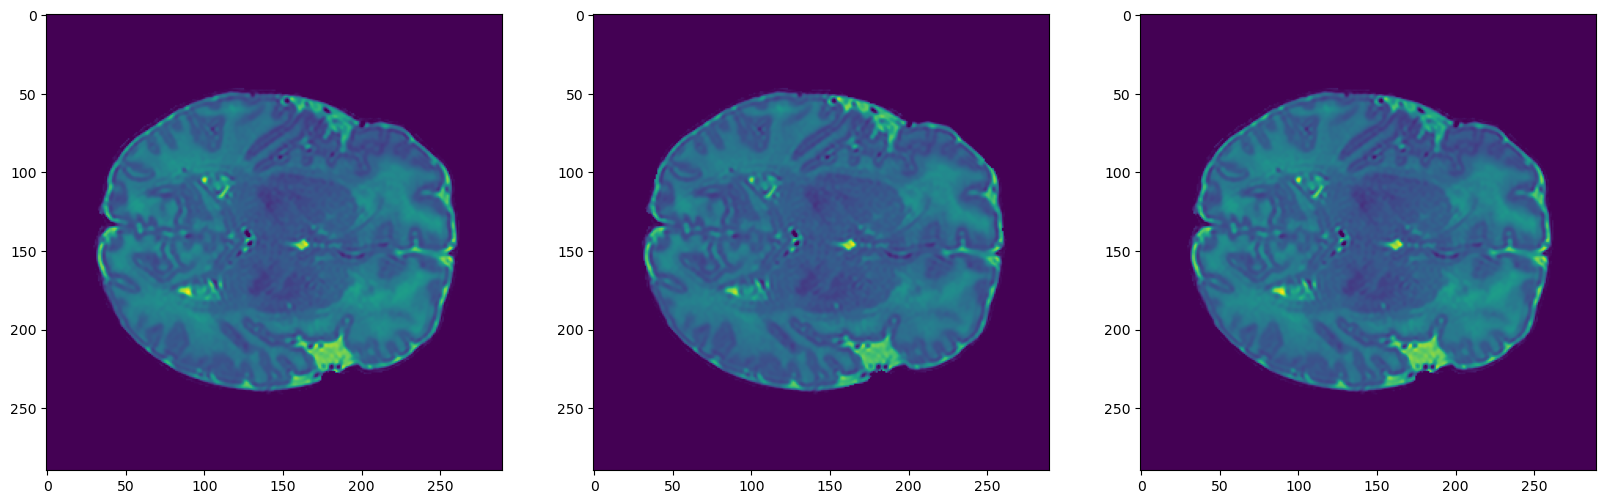

In [73]:
### reference mask vs derived mask (bet2)

fig,ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(ref_img[:,:,101])
ax[1].imshow(stripped[:,:,101])
ax[2].imshow(ants_masked.numpy()[:,:,101])